In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch
from knn import uknn_scoring, uknn_gridsearch
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## Amazon-reviews

In [2]:
# !mkdir -p data/amazon_reviews
# !wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Kindle_Store.csv --no-check-certificate
# !mv Kindle_Store.csv data/amazon_reviews/

In [68]:
reviews = pd.read_csv("data/amazon_reviews/Kindle_Store.csv", names=["userid", "itemid", "rating", "timestamp"])

In [69]:
len(reviews)

5722988

In [70]:
reviews.nunique()

userid        493849
itemid       2409262
rating             6
timestamp       7202
dtype: int64

In [71]:
# filtering

k_filter = 20

n_interactions = reviews.groupby("itemid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.itemid.isin(enough)]

n_interactions = reviews.groupby("userid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.userid.isin(enough)]

In [72]:
len(reviews) / 1e6

0.711852

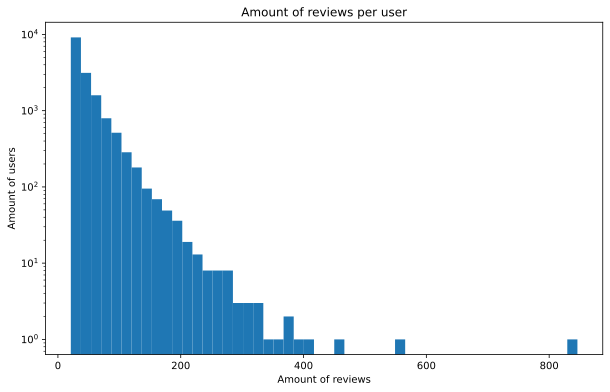

In [73]:
plt.hist(reviews.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.xlabel("Amount of reviews")
plt.ylabel("Amount of users")
plt.show()

In [74]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(reviews, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(248868, 367288, 7968)

In [75]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(95319, 92013, 2750)

In [76]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

## Popular

In [77]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [78]:
topn = 20

In [79]:
alphas = [2 ** p for p in range(12)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

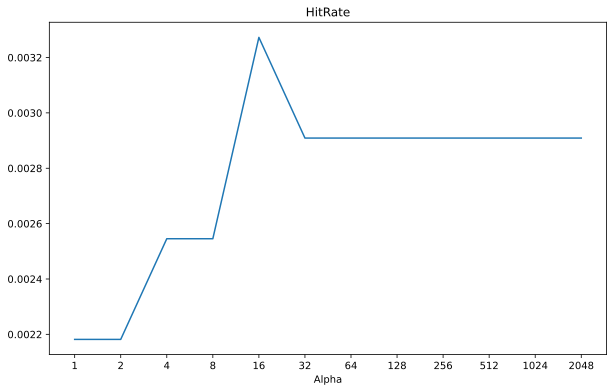

In [80]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

In [81]:
popular_results = popular_results.sort_values("metric", ascending=False)

popular_results.head()

,alpha,metric
4,16,0.003273
5,32,0.002909
6,64,0.002909
7,128,0.002909
8,256,0.002909


## Pure SVD

In [82]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [97]:
ranks = [b * 2 ** p for p in range(0, 10) for b in [2, 3]]
ranks

[2,
 3,
 4,
 6,
 8,
 12,
 16,
 24,
 32,
 48,
 64,
 96,
 128,
 192,
 256,
 384,
 512,
 768,
 1024,
 1536]

In [98]:
%%time
svd_results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn=20)

Interaction matrix shape: (2848, 17780)
Matrix density: 0.0018791826759014675
CPU times: user 1min 55s, sys: 15 s, total: 2min 10s
Wall time: 36.9 s


In [99]:
svd_results = pd.DataFrame(svd_results)

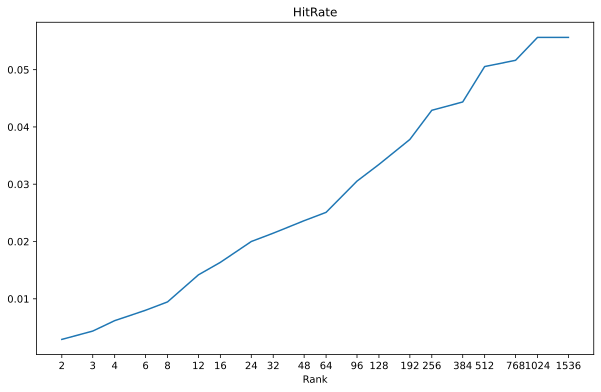

In [100]:
plt.plot(svd_results["rank"], svd_results["metric"])
plt.xscale("log")
plt.xticks(svd_results["rank"], svd_results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [101]:
svd_results = svd_results.sort_values("metric", ascending=False)

svd_results.head()

,rank,metric
19,1536,0.055636
18,1024,0.055636
17,768,0.051636
16,512,0.050545
15,384,0.044364


## Scaled SVD

In [102]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [103]:
ranks = [b * 2 ** p for p in range(0, 10) for b in [2, 3]]
ranks

[2,
 3,
 4,
 6,
 8,
 12,
 16,
 24,
 32,
 48,
 64,
 96,
 128,
 192,
 256,
 384,
 512,
 768,
 1024,
 1536]

In [104]:
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [105]:
%%time
scaled_svd_results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn)

Scaling 0.1
Scaling 0.3
Scaling 0.5
Scaling 0.7
Scaling 0.9
CPU times: user 15min 54s, sys: 1min 31s, total: 17min 25s
Wall time: 6min 1s


In [106]:
results = pd.DataFrame(scaled_svd_results)

results = results.sort_values("metric", ascending=False)

results.head()

,rank,scaling,metric
78,1024,0.7,0.057455
98,1024,0.9,0.057455
77,768,0.7,0.056727
99,1536,0.9,0.054545
79,1536,0.7,0.054545


# UserKNN

In [107]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [108]:
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, None]

In [109]:
%%time
results = uknn_gridsearch(k_vals, trainval, testval, holdoutval, data_description, topn=20)

CPU times: user 5.41 s, sys: 1.41 s, total: 6.82 s
Wall time: 6.9 s


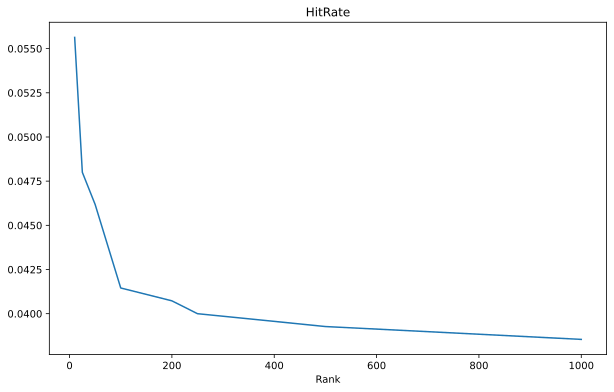

In [110]:
plt.plot(k_vals[:-1], list(results.values())[:-1])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()